# gnn_energy_regression.py

In [ ]:


import os
import random
import pickle
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

# ==================== Utils ====================

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def _reshape_feat(tensor, d):
    """Rende [B, F] sia per singolo Data che per Batch."""
    if hasattr(d, "num_graphs"):  # Batch
        return tensor.view(d.num_graphs, -1)
    else:  # singolo Data
        return tensor.view(1, -1)

# Getter unici per le extra (usa i nomi effettivi presenti nei Data)
EXTRA_GETTERS = {
    "atomic_one_hot":      lambda d: _reshape_feat(d.atomic_one_hot, d),
    "space_group_number":  lambda d: _reshape_feat(d.space_group_number, d),
    "crystal_system":      lambda d: _reshape_feat(d.crystal_system, d),
    "oms":                 lambda d: _reshape_feat(d.oms, d),
    # ATTENZIONE: nel tuo dataset il campo si chiama "cordinates" (non "coordinates")
    "cordinates":          lambda d: _reshape_feat(d.cordinates[0], d),
}

def compute_extras_dim(sample_data, selected_extras):
    dim = 0
    for name in selected_extras:
        if name not in EXTRA_GETTERS:
            raise ValueError(f"Feature extra sconosciuta: {name}")
        dim += EXTRA_GETTERS[name](sample_data).shape[1]
    return dim

def build_extras_tensor(data, selected_extras):
    if not selected_extras:
        return None
    parts = [EXTRA_GETTERS[name](data) for name in selected_extras]
    return torch.cat(parts, dim=1)

def extras_suffix(selected_extras):
    if not selected_extras:
        return "no_extras"
    return "_".join(selected_extras)

# ==================== Dataset loader ====================

# Adatta a come carichi i tuoi dati
from load_data import LMDBDataset

def load_pyg_obj_energy(path_to_mdb="mof_syncondition_data"):
    data = []
    for d in LMDBDataset(lmdb_path=path_to_mdb):
        d.x = d.x.float()
        data.append(d)
    return data

# ==================== Model ====================

class MetalSaltGNN_Ablation(nn.Module):
    def __init__(
        self,
        node_in_dim,
        edge_in_dim,
        lattice_in_dim=9,
        hidden_dim=128,
        num_gnn_layers=4,
        num_lattice_layers=2,
        num_mlp_layers=2,
        dropout=0.2,
        use_batchnorm=True,
        selected_extras=None,
        extras_dim=0
    ):
        super().__init__()
        self.use_batchnorm = use_batchnorm
        self.dropout = dropout
        self.selected_extras = selected_extras or []
        self.extras_dim = extras_dim

        # Edge encoder (-> hidden_dim) per usare edge_dim=hidden_dim in GINE
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # GINE stack
        self.gnn_layers = nn.ModuleList()
        self.gnn_bns = nn.ModuleList() if use_batchnorm else None
        for i in range(num_gnn_layers):
            in_dim = node_in_dim if i == 0 else hidden_dim
            mlp = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.gnn_layers.append(GINEConv(mlp, edge_dim=hidden_dim))
            if use_batchnorm:
                self.gnn_bns.append(nn.BatchNorm1d(hidden_dim))

        # Lattice encoder
        lattice_layers = []
        in_dim = lattice_in_dim
        for _ in range(max(1, num_lattice_layers - 1)):
            lattice_layers += [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
            if use_batchnorm:
                lattice_layers.append(nn.BatchNorm1d(hidden_dim))
            in_dim = hidden_dim
        lattice_layers.append(nn.Linear(in_dim, hidden_dim))
        self.lattice_encoder = nn.Sequential(*lattice_layers)

        # Final MLP head -> output 1 per regressione
        final_in = hidden_dim * 2 + self.extras_dim
        mlp_layers = []
        in_dim = final_in
        for _ in range(max(1, num_mlp_layers - 1)):
            mlp_layers += [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
            if use_batchnorm:
                mlp_layers.append(nn.BatchNorm1d(hidden_dim))
            mlp_layers.append(nn.Dropout(p=dropout))
            in_dim = hidden_dim
        mlp_layers.append(nn.Linear(in_dim, 1))
        self.final_mlp = nn.Sequential(*mlp_layers)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        e = self.edge_encoder(edge_attr)
        for i, conv in enumerate(self.gnn_layers):
            x = conv(x, edge_index, e)
            x = F.relu(x)
            if self.use_batchnorm:
                x = self.gnn_bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Graph pooling
        x_pool = global_mean_pool(x, batch)

        # Lattice
        lattice = data.lattice.view(-1, 9)
        lattice_feat = self.lattice_encoder(lattice)

        # Extras
        extras = build_extras_tensor(data, self.selected_extras)
        if extras is not None:
            final_in = torch.cat([x_pool, lattice_feat, extras], dim=1)
        else:
            final_in = torch.cat([x_pool, lattice_feat], dim=1)

        out = self.final_mlp(final_in)     # [B, 1]
        return out.squeeze(-1)             # [B]

# ==================== Train / Eval ====================

def train_one_epoch(model, loader, criterion, optimizer, device, target_name="energy_scaled", grad_clip=None):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        preds = model(data)                               # [B]
        target = data[target_name].view(-1).float()       # [B]
        loss = criterion(preds, target)                   # MAE o Huber -> >= 0
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(loader))


@torch.no_grad()
def evaluate(model, loader, device, target_name="energy_scaled", scaler=None, loss_kind="l1"):
    model.eval()
    losses = []
    y_true_scaled, y_pred_scaled = [], []

    for data in loader:
        data = data.to(device)
        preds = model(data)  # [B]
        target = data[target_name].view(-1).float()
        if loss_kind == "l1":
            loss_batch = F.l1_loss(preds, target, reduction="mean")
        elif loss_kind == "huber":
            loss_batch = F.smooth_l1_loss(preds, target, reduction="mean")
        else:
            # default L1
            loss_batch = F.l1_loss(preds, target, reduction="mean")
        losses.append(loss_batch.item())

        y_true_scaled.append(target.cpu())
        y_pred_scaled.append(preds.cpu())

    y_true_scaled = torch.cat(y_true_scaled).numpy()
    y_pred_scaled = torch.cat(y_pred_scaled).numpy()

    results = {
        "val_loss_scaled": float(np.mean(losses)),
    }

    if scaler is not None:
        y_true = scaler.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        mae = float(np.mean(np.abs(y_pred - y_true)))
        rmse = float(np.sqrt(np.mean((y_pred - y_true) ** 2)))
        r2 = float(r2_score(y_true, y_pred))
        results.update({"MAE": mae, "RMSE": rmse, "R2": r2})

    return results

# ==================== Main ====================


/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
batch_size = 128
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- Carica dataset
dataset = load_pyg_obj_energy(path_to_mdb="../../data/stability_energy_data/")
assert len(dataset) > 0, "Dataset vuoto!"

# ---- Split
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# ---- Prepara target arrays
y_train = np.array([d.energy for d in train_dataset])
y_val   = np.array([d.energy for d in val_dataset])
y_test  = np.array([d.energy for d in test_dataset])

# ---- Clipping robusto definito dal TRAIN
q_low, q_high = np.percentile(y_train, [1, 99])
def clip_like_train(arr): return np.clip(arr, q_low, q_high)
y_train_c = clip_like_train(y_train)
y_val_c   = clip_like_train(y_val)
y_test_c  = clip_like_train(y_test)

# ---- Scaler (fit SOLO sul train) e salvataggio
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(y_train_c.reshape(-1, 1))
with open("target_scaler_energy.pkl", "wb") as f:
    pickle.dump(scaler, f)

# ---- Trasforma y
y_train_scaled = scaler.transform(y_train_c.reshape(-1, 1)).ravel()
y_val_scaled   = scaler.transform(y_val_c.reshape(-1, 1)).ravel()
y_test_scaled  = scaler.transform(y_test_c.reshape(-1, 1)).ravel()

# ---- Attacca il campo energy_scaled agli oggetti Data
def attach_scaled_energy(subset, scaled_values):
    for data, y in zip(subset, scaled_values):
        data.energy_scaled = torch.tensor(y, dtype=torch.float32)
attach_scaled_energy(train_dataset, y_train_scaled)
attach_scaled_energy(val_dataset,   y_val_scaled)
attach_scaled_energy(test_dataset,  y_test_scaled)

# ---- DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

# ---- Dimensioni input
node_in_dim    = dataset[0].x.shape[1]
edge_in_dim    = dataset[0].edge_attr.shape[1]
lattice_in_dim = 9

# ---- Selezione extra
selected_extras = ["atomic_one_hot", "cordinates", "oms", "space_group_number"]
selected_extras = np.sort(selected_extras).tolist()
extras_dim = compute_extras_dim(dataset[0], selected_extras)

# ---- Iperparametri
hidden_dim = 128
dropout = 0.35
lr = 1e-3
weight_decay = 1e-4
patience = 20
max_epochs = 1000
grad_clip = 1.0  # opzionale

# ---- Modello
model = MetalSaltGNN_Ablation(
    node_in_dim=node_in_dim,
    edge_in_dim=edge_in_dim,
    lattice_in_dim=lattice_in_dim,
    hidden_dim=hidden_dim,
    num_gnn_layers=2,
    num_lattice_layers=2,
    num_mlp_layers=2,
    dropout=dropout,
    use_batchnorm=True,
    selected_extras=selected_extras,
    extras_dim=extras_dim
).to(device)

# ---- Loss & Optimizer (REGRESSIONE!)
criterion = nn.L1Loss()  # 
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# ---- Training loop con early stopping su val_loss_scaled
best_metric = np.inf
epochs_no_improve = 0
checkpoint_name = "trained_models/energy_regression.pt"
os.makedirs(os.path.dirname(checkpoint_name), exist_ok=True)

Device: cuda


In [43]:
node_in_dim,edge_in_dim,lattice_in_dim,hidden_dim,2,2,2,dropout,selected_extras,extras_dim

(4,
 1,
 9,
 128,
 2,
 2,
 2,
 0.35,
 ['atomic_one_hot', 'cordinates', 'oms', 'space_group_number'],
 448)

In [ ]:
for epoch in range(1, max_epochs + 1):
    train_loss = train_one_epoch(
        model, train_loader, criterion, optimizer, device,
        target_name="energy_scaled", grad_clip=grad_clip
    )
    res_val = evaluate(
        model, val_loader, device,
        target_name="energy_scaled",
        scaler=scaler, loss_kind="l1"
    )
    print(
        f"Epoch {epoch:04d} | "
        f"train loss (scaled MAE) = {train_loss:.4f} | "
        f"val loss (scaled MAE) = {res_val['val_loss_scaled']:.4f} | "
        f"val MAE = {res_val.get('MAE', float('nan')):.4f} | "
        f"val RMSE = {res_val.get('RMSE', float('nan')):.4f} | "
        f"val R2 = {res_val.get('R2', float('nan')):.4f}"
    )

    if res_val["val_loss_scaled"] < best_metric:
        best_metric = res_val["val_loss_scaled"]
        epochs_no_improve = 0
        torch.save(model.state_dict(), checkpoint_name)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# ---- Test con best checkpoint
model.load_state_dict(torch.load(checkpoint_name, map_location=device))
res_test = evaluate(
    model, test_loader, device,
    target_name="energy_scaled",
    scaler=scaler, loss_kind="l1"
)
print("\n==== TEST RESULTS ====")
print(
    f"Test loss (scaled MAE) = {res_test['val_loss_scaled']:.4f} | "
    f"MAE = {res_test.get('MAE', float('nan')):.4f} | "
    f"RMSE = {res_test.get('RMSE', float('nan')):.4f} | "
    f"R2 = {res_test.get('R2', float('nan')):.4f}"
)

NameError: name 'model' is not defined

In [42]:
checkpoint_name

'trained_models/energy_regression.pt'

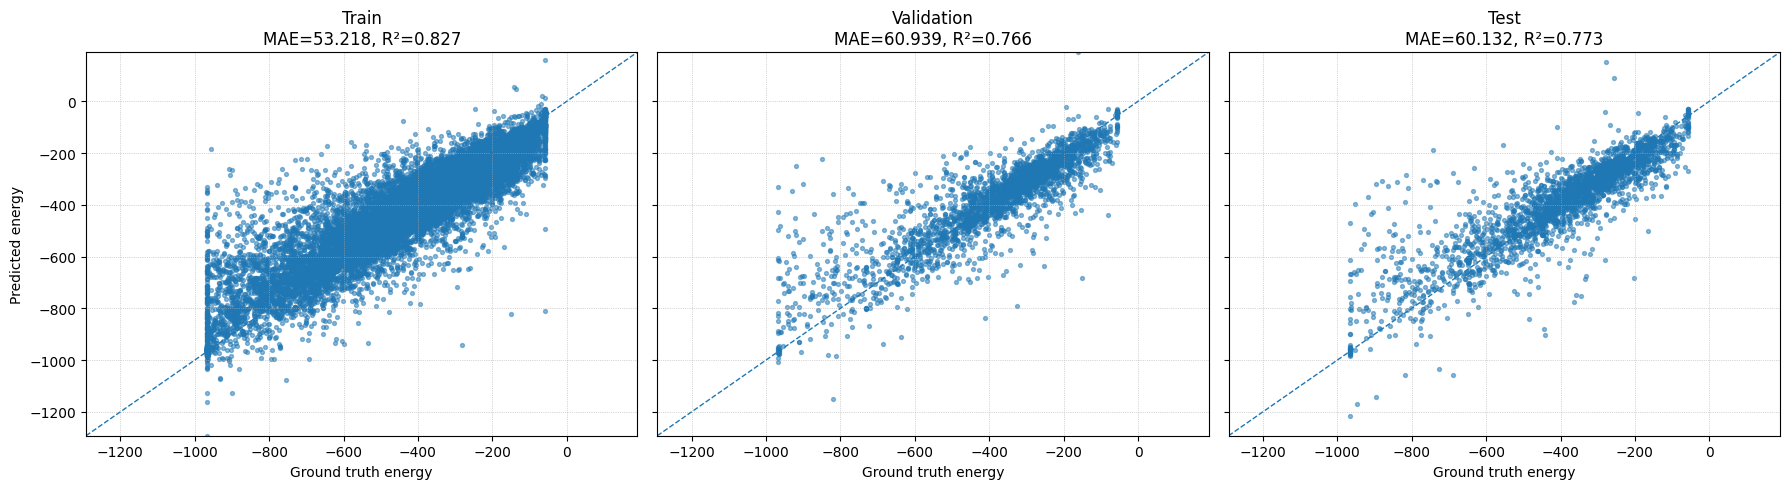

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# Carica il best checkpoint
model.load_state_dict(torch.load(checkpoint_name, map_location=device))
model.eval()

@torch.no_grad()
def collect_gt_pred(loader, model, device, scaler):
    gt, pred = [], []
    for data in loader:
        data = data.to(device)
        v = model(data)  # pred scaled
        v = scaler.inverse_transform(v.detach().cpu().numpy().reshape(-1, 1)).ravel()
        pred.extend(v)
        a = scaler.inverse_transform(
            data.energy_scaled.detach().cpu().numpy().reshape(-1, 1)
        ).ravel()
        gt.extend(a)
    gt = np.asarray(gt)
    pred = np.asarray(pred)
    return gt, pred

# Raccogli per i tre split
gt_tr, pr_tr = collect_gt_pred(train_loader, model, device, scaler)
gt_va, pr_va = collect_gt_pred(val_loader,   model, device, scaler)
gt_te, pr_te = collect_gt_pred(test_loader,  model, device, scaler)

# Metriche
def metrics(y, yhat):
    mae = mean_absolute_error(y, yhat)
    r2  = r2_score(y, yhat)
    return mae, r2

mae_tr, r2_tr = metrics(gt_tr, pr_tr)
mae_va, r2_va = metrics(gt_va, pr_va)
mae_te, r2_te = metrics(gt_te, pr_te)

# Limiti comuni per assi (stessa scala su tutti i subplot)
all_gt = np.concatenate([gt_tr, gt_va, gt_te])
all_pr = np.concatenate([pr_tr, pr_va, pr_te])
vmin = float(np.min([all_gt.min(), all_pr.min()]))
vmax = float(np.max([all_gt.max(), all_pr.max()]))

# Plot 3 in riga
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

def scatter_panel(ax, gt, pr, title, mae, r2):
    ax.scatter(gt, pr, s=8, alpha=0.5)
    ax.plot([vmin, vmax], [vmin, vmax], linestyle="--", linewidth=1)  # y=x
    ax.set_title(f"{title}\nMAE={mae:.3f}, R²={r2:.3f}")
    ax.set_xlabel("Ground truth energy")
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.grid(True, linestyle=":", linewidth=0.5)

scatter_panel(axes[0], gt_tr, pr_tr, "Train", mae_tr, r2_tr)
scatter_panel(axes[1], gt_va, pr_va, "Validation", mae_va, r2_va)
axes[1].set_ylabel("")  # per non ripetere
scatter_panel(axes[2], gt_te, pr_te, "Test", mae_te, r2_te)

# Etichetta Y sul primo pannello
axes[0].set_ylabel("Predicted energy")

plt.tight_layout()
plt.show()

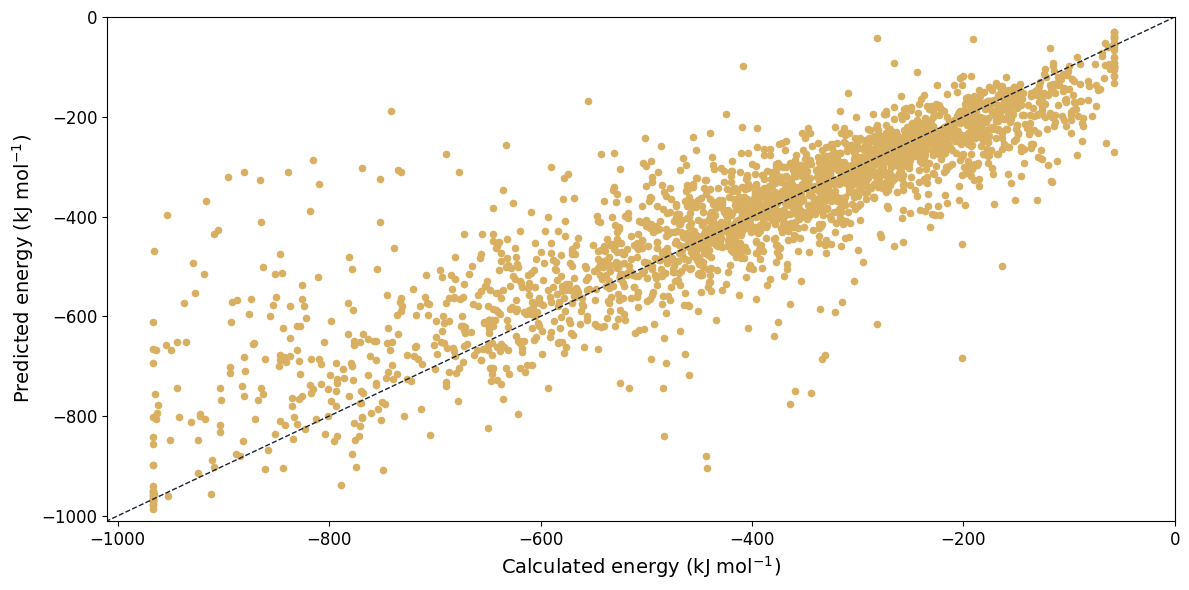

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


gt = gt_te
pr = pr_te
title = "Test"
mae = mae_te
r2 = r2_te


# "#d9b061" and "#192231"
# plt.ylabel(fontsize=14)
# plt.xlabel(fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)


ax.scatter(gt, pr, s=20, alpha=1,color="#d9b061", edgecolors="#d9b061")
ax.plot([vmin, vmax], [vmin, vmax], linestyle="--", linewidth=1,color="#192231")  # y=x

#ax.set_title(f"{title}\nMAE={mae:.3f}, R²={r2:.3f}")
ax.set_xlabel(r"Calculated energy (kJ mol$^{-1}$)",fontsize=14)
ax.set_xlim(-1010, 0)
ax.set_ylim(-1010, 0)
ax.set_ylabel(r"Predicted energy (kJ mol$^{-1}$)",fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.tight_layout()
plt.savefig("Predicted_energy.png", bbox_inches="tight", dpi=400)
plt.show()

# real world-experiment

In [6]:
import os
from mofstructure import structure, mofdeconstructor
from mofstructure.filetyper import load_iupac_names
from fairmofsyncondition.read_write import cheminfo2iupac, coords_library, filetyper
from ase.data import atomic_numbers
from ase.io import read
import torch


inchi_corrector = {
    "FDTQOZYHNDMJCM-UHFFFAOYSA-N":"benzene-1,4-dicarboxylic acid"
}
def get_ligand_iupacname(ligand_inchi):
    print(ligand_inchi)
    name = load_iupac_names().get(ligand_inchi, None)
    if name is None:
        pubchem = cheminfo2iupac.pubchem_to_inchikey(ligand_inchi, name='inchikey')
        if pubchem is None:
            name = inchi_corrector.get(ligand_inchi, ligand_inchi)
        else:
            pubchem.get('iupac_name', ligand_inchi)
    return name


def load_system(filename):
    """
    A function to extract
    """
    data = {}
    os.makedirs('LigandsXYZ', exist_ok=True)
    ase_data = read(filename)
    structure_data = structure.MOFstructure(ase_atoms=ase_data)
    _, ligands = structure_data.get_ligands()

    inchikeys = [ligand.info.get('inchikey') for ligand in ligands]
    for inchi, ligand in zip(inchikeys, ligands):
        ligand.write(f'LigandsXYZ/{inchi}.xyz')
    ligands_names = [get_ligand_iupacname(i) for i in inchikeys]
    general = structure_data.get_oms()
    oms = general.get('has_oms')
    metal_symbols = general.get('metals')
    metals_atomic_number = [atomic_numbers[i] for i in metal_symbols]
    torch_data = coords_library.ase_to_pytorch_geometric(ase_data)
    oms = torch.tensor([1 if  oms else 0], dtype=torch.int16)
    torch_data.oms = oms
    data['general'] = general
    return torch_data, metals_atomic_number, inchikeys, ligands_names

In [47]:
from mofstructure.structure import MOFstructure
from fairmofsyncondition.read_write.coords_library import pytorch_geometric_to_ase

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from mofstructure.structure import MOFstructure
from tqdm import tqdm
import os
convert_metals = {j:i for i,j in enumerate(mofdeconstructor.transition_metals()[1:])}
convert_struct = {'cubic':0, 'hexagonal':1, 'monoclinic':2, 'orthorhombic':3, 'tetragonal':4,'triclinic':5, 'trigonal':6}


name_mof = "EDUSIF.cif"
torch_data, metal_atomic_number, inch, lig = load_system(name_mof)


d = torch_data

# =======================
# Parte 1: atomic one-hot
# =======================
node_features = d.x.numpy()
atom_num = node_features[:, 0].astype(int)
a, b = np.unique(atom_num, return_counts=True)
emb = torch.zeros(120)
for aa, bb in zip(a, b):
    emb[aa] = bb
d.atomic_one_hot = emb



# =======================
# Parte 2: struttura ASE
# =======================
ase_atoms = pytorch_geometric_to_ase(d)
stru = MOFstructure(ase_atoms)
pymat = AseAtomsAdaptor.get_structure(ase_atoms)

# =======================
# Parte 3: OMS
# =======================
emb = torch.zeros(96)
tmp_dict = dict()
for i in stru.get_oms()["metal_info"]:
    cord = i["coordination_number"]
    metal = i["metal"]

    if metal in tmp_dict:
        if cord > tmp_dict[metal]:
            tmp_dict[metal] = cord
    else:
        tmp_dict[metal] = cord

for i, j in tmp_dict.items():
    emb[convert_metals[i]] = j
d.cordinates = [emb]

# =======================
# Parte 4: spazio e sistema cristallino
# =======================
sga = SpacegroupAnalyzer(pymat)
space_group_number = sga.get_space_group_number()
emb = torch.zeros(231)
emb[space_group_number] = 1
d.space_group_number = emb

get_crystal_system = sga.get_crystal_system()
emb = torch.zeros(7)
emb[convert_struct[get_crystal_system]] = 1
d.crystal_system = emb
# =======================
# Parte 5: altri attributi
# =======================
d.oms = d.oms.view(1, 1).float()



selected_extras = ["atomic_one_hot", "cordinates", "oms","space_group_number"]
# imoprtant: for saving
selected_extras = np.sort(selected_extras).tolist()


# ---- Modello
model = MetalSaltGNN_Ablation(
    node_in_dim=node_in_dim,
    edge_in_dim=edge_in_dim,
    lattice_in_dim=lattice_in_dim,
    hidden_dim=hidden_dim,
    num_gnn_layers=2,
    num_lattice_layers=2,
    num_mlp_layers=2,
    dropout=dropout,
    use_batchnorm=True,
    selected_extras=selected_extras,
    extras_dim=extras_dim
).to(device)

# ---- Test con best checkpoint
model.load_state_dict(torch.load(checkpoint_name, map_location=device))
model.eval()

import torch.nn.functional as F

pred = model(d.to(device))

print("energy of ",name_mof, scaler.inverse_transform(pred.detach().cpu().numpy().reshape(-1, 1)).item())

*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): Zn(1); Metal was disconnected
*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): Zn(1); Metal was disconnected
*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): O(1)
*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): O(1)


FDTQOZYHNDMJCM-UHFFFAOYSA-N


/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/pymatgen/io/cif.py:1606: FutureWarning: We strongly discourage using implicit binary/text `mode`, and this would not be allowed after 2025-06-01. I.e. you should pass t/b in `mode`.
  with zopen(filename, mode=mode) as file:


energy of  EDUSIF.cif -590.9739379882812


/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/pymatgen/symmetry/analyzer.py:137: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  return int(self._space_group_data["number"])


In [48]:
from mofstructure.structure import MOFstructure
from fairmofsyncondition.read_write.coords_library import pytorch_geometric_to_ase

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from mofstructure.structure import MOFstructure
from tqdm import tqdm
import os
convert_metals = {j:i for i,j in enumerate(mofdeconstructor.transition_metals()[1:])}
convert_struct = {'cubic':0, 'hexagonal':1, 'monoclinic':2, 'orthorhombic':3, 'tetragonal':4,'triclinic':5, 'trigonal':6}


name_mof = "Zn2C43N6H29O8.cif"
torch_data, metal_atomic_number, inch, lig = load_system(name_mof)


d = torch_data

# =======================
# Parte 1: atomic one-hot
# =======================
node_features = d.x.numpy()
atom_num = node_features[:, 0].astype(int)
a, b = np.unique(atom_num, return_counts=True)
emb = torch.zeros(120)
for aa, bb in zip(a, b):
    emb[aa] = bb
d.atomic_one_hot = emb



# =======================
# Parte 2: struttura ASE
# =======================
ase_atoms = pytorch_geometric_to_ase(d)
stru = MOFstructure(ase_atoms)
pymat = AseAtomsAdaptor.get_structure(ase_atoms)

# =======================
# Parte 3: OMS
# =======================
emb = torch.zeros(96)
tmp_dict = dict()
for i in stru.get_oms()["metal_info"]:
    cord = i["coordination_number"]
    metal = i["metal"]

    if metal in tmp_dict:
        if cord > tmp_dict[metal]:
            tmp_dict[metal] = cord
    else:
        tmp_dict[metal] = cord

for i, j in tmp_dict.items():
    emb[convert_metals[i]] = j
d.cordinates = [emb]

# =======================
# Parte 4: spazio e sistema cristallino
# =======================
sga = SpacegroupAnalyzer(pymat)
space_group_number = sga.get_space_group_number()
emb = torch.zeros(231)
emb[space_group_number] = 1
d.space_group_number = emb

get_crystal_system = sga.get_crystal_system()
emb = torch.zeros(7)
emb[convert_struct[get_crystal_system]] = 1
d.crystal_system = emb
# =======================
# Parte 5: altri attributi
# =======================
d.oms = d.oms.view(1, 1).float()



selected_extras = ["atomic_one_hot", "cordinates", "oms","space_group_number"]
# imoprtant: for saving
selected_extras = np.sort(selected_extras).tolist()


# ---- Modello
model = MetalSaltGNN_Ablation(
    node_in_dim=node_in_dim,
    edge_in_dim=edge_in_dim,
    lattice_in_dim=lattice_in_dim,
    hidden_dim=hidden_dim,
    num_gnn_layers=2,
    num_lattice_layers=2,
    num_mlp_layers=2,
    dropout=dropout,
    use_batchnorm=True,
    selected_extras=selected_extras,
    extras_dim=extras_dim
).to(device)

# ---- Test con best checkpoint
model.load_state_dict(torch.load(checkpoint_name, map_location=device))
model.eval()

import torch.nn.functional as F

pred = model(d.to(device))

print("energy of ",name_mof, scaler.inverse_transform(pred.detach().cpu().numpy().reshape(-1, 1)).item())

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): O(1); C(3)
*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): O(1); C(3)


MGFJDEHFNMWYBD-OWOJBTEDSA-N
VIORWCNXRPKALR-UHFFFAOYSA-N


2025-09-11 15:44:17,898 - INFO - 'PUGREST.NotFound: No CID found that matches the given InChI key'
/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/pymatgen/io/cif.py:1606: FutureWarning: We strongly discourage using implicit binary/text `mode`, and this would not be allowed after 2025-06-01. I.e. you should pass t/b in `mode`.
  with zopen(filename, mode=mode) as file:


energy of  Zn2C43N6H29O8.cif -266.8030700683594


/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/pymatgen/symmetry/analyzer.py:137: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  return int(self._space_group_data["number"])


In [49]:
from mofstructure.structure import MOFstructure
from fairmofsyncondition.read_write.coords_library import pytorch_geometric_to_ase

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from mofstructure.structure import MOFstructure
from tqdm import tqdm
import os
convert_metals = {j:i for i,j in enumerate(mofdeconstructor.transition_metals()[1:])}
convert_struct = {'cubic':0, 'hexagonal':1, 'monoclinic':2, 'orthorhombic':3, 'tetragonal':4,'triclinic':5, 'trigonal':6}


name_mof = "ZnC5HO5.cif"
torch_data, metal_atomic_number, inch, lig = load_system(name_mof)


d = torch_data

# =======================
# Parte 1: atomic one-hot
# =======================
node_features = d.x.numpy()
atom_num = node_features[:, 0].astype(int)
a, b = np.unique(atom_num, return_counts=True)
emb = torch.zeros(120)
for aa, bb in zip(a, b):
    emb[aa] = bb
d.atomic_one_hot = emb



# =======================
# Parte 2: struttura ASE
# =======================
ase_atoms = pytorch_geometric_to_ase(d)
stru = MOFstructure(ase_atoms)
pymat = AseAtomsAdaptor.get_structure(ase_atoms)

# =======================
# Parte 3: OMS
# =======================
emb = torch.zeros(96)
tmp_dict = dict()
for i in stru.get_oms()["metal_info"]:
    cord = i["coordination_number"]
    metal = i["metal"]

    if metal in tmp_dict:
        if cord > tmp_dict[metal]:
            tmp_dict[metal] = cord
    else:
        tmp_dict[metal] = cord

for i, j in tmp_dict.items():
    emb[convert_metals[i]] = j
d.cordinates = [emb]

# =======================
# Parte 4: spazio e sistema cristallino
# =======================
sga = SpacegroupAnalyzer(pymat)
space_group_number = sga.get_space_group_number()
emb = torch.zeros(231)
emb[space_group_number] = 1
d.space_group_number = emb

get_crystal_system = sga.get_crystal_system()
emb = torch.zeros(7)
emb[convert_struct[get_crystal_system]] = 1
d.crystal_system = emb
# =======================
# Parte 5: altri attributi
# =======================
d.oms = d.oms.view(1, 1).float()



selected_extras = ["atomic_one_hot", "cordinates", "oms","space_group_number"]
# imoprtant: for saving
selected_extras = np.sort(selected_extras).tolist()


# ---- Modello
model = MetalSaltGNN_Ablation(
    node_in_dim=node_in_dim,
    edge_in_dim=edge_in_dim,
    lattice_in_dim=lattice_in_dim,
    hidden_dim=hidden_dim,
    num_gnn_layers=2,
    num_lattice_layers=2,
    num_mlp_layers=2,
    dropout=dropout,
    use_batchnorm=True,
    selected_extras=selected_extras,
    extras_dim=extras_dim
).to(device)

# ---- Test con best checkpoint
model.load_state_dict(torch.load(checkpoint_name, map_location=device))
model.eval()

import torch.nn.functional as F

pred = model(d.to(device))

print("energy of ",name_mof, scaler.inverse_transform(pred.detach().cpu().numpy().reshape(-1, 1)).item())

*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): O(1)
*** Open Babel Warning  in InChI code
  #1 :Accepted unusual valence(s): O(1)


RESFABUZNSNZRT-UHFFFAOYSA-N


2025-09-11 15:44:36,655 - INFO - 'PUGREST.NotFound: No CID found that matches the given InChI key'
/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/pymatgen/io/cif.py:1606: FutureWarning: We strongly discourage using implicit binary/text `mode`, and this would not be allowed after 2025-06-01. I.e. you should pass t/b in `mode`.
  with zopen(filename, mode=mode) as file:


energy of  ZnC5HO5.cif -324.9798278808594


/home/antonio/miniconda3/envs/fairmof/lib/python3.11/site-packages/pymatgen/symmetry/analyzer.py:137: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  return int(self._space_group_data["number"])


energy of  EDUSIF.cif -590.9739379882812
